In [1]:
! pip install comet_ml lightning
import torch
from torch.nn import functional as F
import torch.optim as optim
from torch import nn
import einops
import comet_ml
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

def setup_device():
    if torch.cuda.is_available():
        device = torch.device('cuda')
        # Set default tensor type for cuda
        torch.set_default_dtype(torch.float32)
    elif torch.backends.mps.is_available():
        device = torch.device('mps')
    else:
        device = torch.device('cpu')
        # Ensure we're using float32 on CPU

        torch.set_default_dtype(torch.float64)
    return device

device = setup_device()

print(f"Using {device} device")

# Set random seed for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

!pip install datasets
from datasets import load_dataset


full_dataset = load_dataset("Artificio/WikiArt_Full").with_format("torch")


full_dataset=full_dataset['train']


train_test_split = full_dataset.train_test_split(test_size=0.2)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']

test_val_split = test_dataset.train_test_split(test_size=0.5)
test_dataset = test_val_split['train']
val_dataset = test_val_split['test']


batch_size = 32

enable_pin_memory = True

number_of_workers = 2 # for colab


train_loader = DataLoader(train_dataset, batch_size=batch_size, pin_memory = enable_pin_memory, num_workers=number_of_workers,shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, pin_memory = enable_pin_memory, num_workers=number_of_workers,shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, pin_memory = enable_pin_memory, num_workers=number_of_workers,shuffle=True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 710.5/710.5 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 979.7/979.7 kB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 7.1 MB/s eta 0:00:00
  Attempting uninstall: python-box
    Found existing installation: python-box 7.3.2
    Uninstalling python-box-7.3.2:
      Successfully uninstalled python-box-7.3.2
Using cuda device
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/780 [00:00<?, ?B/s]

(…)-00000-of-00007-dd79acf31a667474.parquet:   0%|          | 0.00/462M [00:00<?, ?B/s]

(…)-00001-of-00007-16d737d74ca9cb8a.parquet:   0%|          | 0.00/463M [00:00<?, ?B/s]

(…)-00002-of-00007-73e15989674f270b.parquet:   0%|          | 0.00/464M [00:00<?, ?B/s]

(…)-00003-of-00007-911b21abee70c83e.parquet:   0%|          | 0.00/464M [00:00<?, ?B/s]

(…)-00004-of-00007-a49c31eac1929942.parquet:   0%|          | 0.00/464M [00:00<?, ?B/s]

(…)-00005-of-00007-053e48131b243ec0.parquet:   0%|          | 0.00/465M [00:00<?, ?B/s]

(…)-00006-of-00007-daeb2ac40cedaee0.parquet:   0%|          | 0.00/464M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/103250 [00:00<?, ? examples/s]

# Drive mount

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Autoencoder definition


In [23]:
class SuperResolutionAutoencoder(nn.Module):
  @staticmethod
  def ConvBlock(in_channels: int, out_channels: int):
      return nn.Sequential(
          nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
          nn.ReLU(True)
      )

  def __init__(self):
    super().__init__()
    #Encoder
    self.conv_1=SuperResolutionAutoencoder.ConvBlock(3,64)
    self.conv_2=SuperResolutionAutoencoder.ConvBlock(64,64)
    self.pool_1=nn.MaxPool2d(kernel_size=2)
    self.drop_1=nn.Dropout(0.3)

    self.conv_3=SuperResolutionAutoencoder.ConvBlock(64,128)
    self.conv_4=SuperResolutionAutoencoder.ConvBlock(128,128)
    self.pool_2=nn.MaxPool2d(kernel_size=2)
    self.conv_5=SuperResolutionAutoencoder.ConvBlock(128,256)

    #Decoder
    self.upsampling_1=nn.UpsamplingBilinear2d(scale_factor=2)
    self.conv_6=SuperResolutionAutoencoder.ConvBlock(256,128)
    self.conv_7=SuperResolutionAutoencoder.ConvBlock(128,128)

    self.upsampling_2=nn.UpsamplingBilinear2d(scale_factor=2)
    self.conv_8=SuperResolutionAutoencoder.ConvBlock(128,64)
    self.conv_9=SuperResolutionAutoencoder.ConvBlock(64,64)

    self.conv_10=nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)

  def forward(self,x):
    #Encoder
    x=self.conv_1(x)
    x2=self.conv_2(x)
    x=self.pool_1(x2)
    x=self.drop_1(x)
    x=self.conv_3(x)
    x4=self.conv_4(x)
    x=self.pool_2(x4)
    x=self.conv_5(x)
    #Decoder
    x=self.upsampling_1(x)
    x=self.conv_6(x)
    x=self.conv_7(x)
    x=x+x4
    x=self.upsampling_2(x)
    x=self.conv_8(x)
    x=self.conv_9(x)
    x=x+x2
    x=self.conv_10(x)
    x=nn.Sigmoid()(x)
    return x




# Lightning module


In [24]:
import pytorch_lightning as pl
import torch.nn.functional as F
from torch.optim import Adam
from torch import nn
import einops
import torch

damage = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Resize((256, 256)),
])
class LModule(pl.LightningModule):
    def __init__(self, learning_rate=1e-3):
        super(LModule, self).__init__()

        self.autoencoder=SuperResolutionAutoencoder().to(device)

        self.learning_rate = learning_rate


        self.save_hyperparameters()

    def forward(self, x):
        x=self.autoencoder(x)
        return x


    def step(self, batch, batch_idx):
        label = batch['image'].to(device).float()
        label=label/255.0
        x=damage(label)

        x_recon = self(x)

        loss = F.mse_loss(x_recon, label)

        return loss

    def training_step(self, batch, batch_idx):
        loss = self.step(batch, batch_idx)
        self.log('train_loss', loss)

        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.step(batch, batch_idx)
        self.log('validation_loss', loss)
        return loss
    def configure_optimizers(self):
        return Adam(self.parameters(), lr=self.learning_rate)

# Training

In [25]:
import comet_ml
from lightning.pytorch.loggers import CometLogger

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping


EXPERIMENT_NAME = "superrresolution_ae"

comet_logger = CometLogger(
    api_key="0RfBkzG1OWWq2b8BwzxjFp0Q2",
    project_name="superresolution2",
    experiment_name=EXPERIMENT_NAME,
)

best_checkpoint = ModelCheckpoint(
    monitor='validation_loss',
    dirpath=f'/content/drive/MyDrive/',
    filename='model-{epoch:02d}-{validation_loss:.2f}',
    save_top_k=1,
    mode='min'
)

last_checkpoint = ModelCheckpoint(
    dirpath=f'/content/drive/MyDrive/',
    filename='model-{epoch:02d}',
    save_top_k=1,
    every_n_epochs=1,
)

early_stopping = EarlyStopping(
    monitor='validation_loss',
    patience=5,
    mode='min'
)

trainer = pl.Trainer(
    max_epochs=15,
    callbacks=[last_checkpoint, best_checkpoint, early_stopping],
    logger=comet_logger
)
lmodule = LModule()
trainer.fit(lmodule, train_loader,val_loader)

INFO: CometLogger will be initialized in online mode
INFO:lightning.pytorch.loggers.comet:CometLogger will be initialized in online mode
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/elpolaco/superresolution2/c3b2563ba5f2418ca487935939affffd

COMET INFO: Couldn't find a Git repository in '/content' nor in any parent dire

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: 
Detected KeyboardInterrupt, attempting graceful shutdown ...
INFO:lightning.pytorch.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : superrresolution_ae
COMET INFO:     url                   : https://www.comet.com/elpolaco/superresolution2/c3b2563ba5f2418ca487935939affffd
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [115]    : (0.0008092947537079453, 0.006191335618495941)
COMET INFO:     validation_loss [2] : (0.0012431020149961114, 0.001641652313992381)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:     Name         : superrresolution_ae
COMET INFO: 

NameError: name 'exit' is not defined

# Testing superresolution

torch.Size([3, 256, 256])


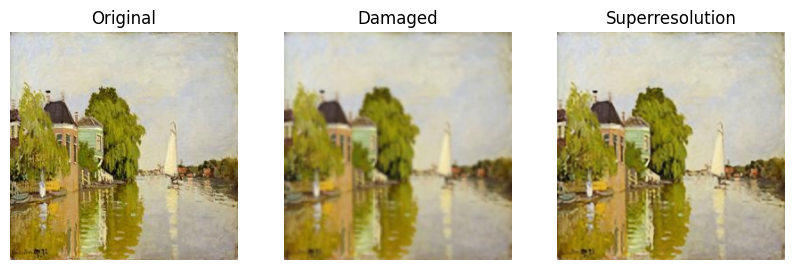

In [33]:
model = LModule.load_from_checkpoint("/content/drive/MyDrive/model-epoch=01-validation_loss=0.00.ckpt")

damage = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Resize((256, 256)),
])

model.eval()

batch=next(iter(test_loader))
test_img=None
model=model.float()
img=batch['image'][0].to(device)
with torch.no_grad():
  x=damage(img/255.0).float()
  test_img = model(x.unsqueeze(0))

fig, axes = plt.subplots(1, 3, figsize=(10, 5))  # 1 row, 2 columns
print(img.shape)
# Plot the first image
axes[0].imshow(img.permute(1,2,0).cpu().numpy())
axes[0].axis('off')  # Hide axis
axes[0].set_title('Original')
# Plot the first image
axes[1].imshow(x.permute(1,2,0).cpu().numpy())
axes[1].axis('off')  # Hide axis
axes[1].set_title('Damaged')
# Plot the second image
axes[2].imshow(test_img.squeeze(0).permute(1,2,0).cpu().numpy())
axes[2].axis('off')  # Hide axis
axes[2].set_title('Superresolution')

# Show the plot
plt.plot()
plt.show()